Немного про суть изучаемых графиков.

Основа это когортный анализ: Каждый конкретный день пользователи нашего приложения состоят из тех, кто только начал его использовать и тех кто уже использовал его ранее - вчера, неделю назад, месяц назад и т.д. Выводы по всей этой куче пользователей сделать нереально! Идея когортного анализа состоит в том, чтобы разделить пользователей на группы по определенным признакам, и отслеживать поведение этих групп во времени. Обычно группы пользователей (когорты) выделяют на основе недели, двух недель, месяца - когда пользователи зарегистрировались в приложении. Выделив такие группы пользователей (когорты) можно следить за ними в течение времени и измерять ключевые метрики для каждой отдельной когорты.
Таким образом, сравнивая показатели разных когорт пользователей можно наглядно сравнивать соответствующие этим периодам времени метрики.

# Проект по когортному анализу продукта

**Контекст:** несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки

**Задача:** разобраться в причинах и помочь компании выйти в плюс

**Данные:**
информация о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

### Загрузка данных и подготовка их к анализу

In [1]:
#импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px

In [2]:
!gdown -- 1Dgy0oeECj0pqpHr-R6DXb3UuUeUi1_br
!gdown -- 1RPYo2NXzT68j67m5BkSsgoWHGdlXT2QA
!gdown -- 1HdBgt4clbNeaDOlyy-cu-13SXi7rodCG

Downloading...
From: https://drive.google.com/uc?id=1Dgy0oeECj0pqpHr-R6DXb3UuUeUi1_br
To: /content/costs_info_short.csv
100% 59.6k/59.6k [00:00<00:00, 50.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RPYo2NXzT68j67m5BkSsgoWHGdlXT2QA
To: /content/orders_info_short.csv
100% 1.57M/1.57M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HdBgt4clbNeaDOlyy-cu-13SXi7rodCG
To: /content/visits_info_short.csv
100% 25.0M/25.0M [00:00<00:00, 132MB/s] 


In [3]:
#загрузим данные в соотвествующие датафреймы
sessions = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
ad_costs = pd.read_csv('costs_info_short.csv')

In [4]:
# информация по датафрейму sessions
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
# доля дубликатов по датафрейму sessions
sessions.duplicated().mean()

0.0

In [6]:
# переименуем столбцы sessions для дальнейшей работы
sessions = sessions.rename(columns={'User Id': 'user_id',
                                'Region': 'region',
                                'Device': 'device',
                                'Channel': 'channel',
                                'Session Start': 'session_start',
                                'Session End': 'session_end'})

In [7]:
# приведём даты к типу datetime
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_end'])

In [8]:
# выведем первые строки датафрейма
sessions.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [9]:
# информация по датафрейму
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [10]:
# доля дубликатов по датафрейму
orders.duplicated().mean()

0.0

In [11]:
# переименуем столбцы sessions для дальнейшей работы
orders = orders.rename(columns={'User Id': 'user_id',
                                'Revenue': 'revenue',
                               'Event Dt': 'event_dt'})

In [12]:
# приведём даты к типу datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [13]:
# выведем первые строки датафрейма
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [14]:
# информация по датафрейму
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [15]:
# приведём даты к типу datetime
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

In [16]:
# доля дубликатов по датафрейму
ad_costs.duplicated().mean()

0.0

In [17]:
# переименуем столбцы sessions для дальнейшей работы
ad_costs = ad_costs.rename(columns={'Channel': 'channel'})

In [18]:
# выведем первые строки датафрейма
ad_costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Промежуточный итог: изменены типы данных для дат на нужные, названия столбцов в таблицах приведены к общему виду

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функции для вычисления метрик

In [19]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    # Cast 'first_ts' column to datetime64 type
    profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])

    # Cast 'first_ts' column to monthly frequency
    profiles['month'] = profiles['first_ts'].dt.to_period('M')

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # # добавляем флаги для всех событий из event_names
    # for event in event_names:
    #     if event in events['event_name'].unique():
    #         profiles[event] = profiles['user_id'].isin(
    #             events.query('event_name == @event')['user_id'].unique()
    #         )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [20]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [21]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [22]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для построения графиков

In [23]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [24]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

In [25]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [26]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составлю профили пользователей. Определю минимальную и максимальную даты привлечения пользователей.
- Выясню, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построю таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаю, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построю таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучу рекламные источники привлечения и определю каналы, из которых пришло больше всего платящих пользователей. Построю таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

#### Профили пользователей

In [27]:
# сохраним результат работы функции
profiles = get_profiles(sessions, orders, ad_costs)

In [28]:
# выведем первые строки датафрейма
profiles.head()

,user_id,first_ts,channel,device,region,month,dt,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05,2019-05-07,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07,2019-07-09,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08,2019-08-22,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10,2019-10-02,False,0.230769


In [29]:
# определим минимальную и максимальную даты в датасете
profiles['dt'].agg(['min', 'max'])

min    2019-05-01
max    2019-10-27
Name: dt, dtype: object

Крайние даты в датафрейме совпадают с нужным для исследования периодом

#### Из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.

In [30]:
# сгруппируем пользователей по region и сделаем вычисления по payer
profiles.groupby('region')['payer'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


- Пользователи приходят из США, Германии, Великобритании, Франции
- Наибольшая доля платящих пользователей в США - 6.9% являются платящими

#### Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.

In [31]:
# сгруппируем пользователей по device и сделаем вычисления по payer
profiles.groupby('device')['payer'].agg(
    ['count', 'mean']).sort_values(by='mean', ascending=False)

,count,mean
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


- Пользователи пользуются Mac, iPhone, Android, PC
- Наибольшая доля платящих пользователей использует Mac - 6.4% являются платящими

#### Рекламные источники привлечения и определение каналов, из которых пришло больше всего платящих пользователей.

In [32]:
# сгруппируем пользователей по channel и сделаем вычисления по payer
profiles.groupby('channel')['payer'].agg(
    ['count', 'mean', 'sum']).sort_values(by='mean', ascending=False)

,count,mean,sum
channel,,,
FaceBoom,29144,0.122049,3557
AdNonSense,3880,0.113402,440
lambdaMediaAds,2149,0.104700,225
TipTop,19561,0.096007,1878
RocketSuperAds,4448,0.079137,352
WahooNetBanner,8553,0.052964,453
YRabbit,4312,0.038265,165
MediaTornado,4364,0.035747,156
LeapBob,8553,0.030633,262


- Наибольшее число платящих пользователей пришло из FaceBoom, TipTop. Органический трафик также принес много платящих пользователей

### Маркетинг

- Общая сумму расходов на маркетинг.
- Распределение трат по рекламным источникам, то есть сколько денег потратили на каждый источник.
- График с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике динамика изменения расходов во времени по месяцам по каждому источнику.
- CAC из каждого источника.


#### Посчитайте общую сумму расходов на маркетинг.

In [33]:
# просуммируем все costs
total_ad_sum = ad_costs['costs'].sum()
print(f'Общая сумма расходов на маркетинг: {total_ad_sum}')

Общая сумма расходов на маркетинг: 105497.30000000002


#### Распределение трат по рекламным источникам

In [34]:
# сгруппируем траты по channel и проведем вычисления по costs
t = ad_costs.groupby('channel')['costs'].sum()\
    .to_frame().sort_values(by='costs', ascending=False)
t['share_of_total'] = t['costs'] / total_ad_sum
t

,costs,share_of_total
channel,,
TipTop,54751.30,0.518983
FaceBoom,32445.60,0.307549
WahooNetBanner,5151.00,0.048826
AdNonSense,3911.25,0.037074
OppleCreativeMedia,2151.25,0.020392
RocketSuperAds,1833.00,0.017375
LeapBob,1797.60,0.017039
lambdaMediaAds,1557.60,0.014764
MediaTornado,954.48,0.009047


- Лидеры по тратам - TipTop (52% бюджета) и FaceBoom (31% бюджета)
- На популярные каналы тратится больше. Судя по проценту видим, что два канала съели более 80% бюджета.

#### Визуализация динамики изменения расходов во времени по неделям, месяцам по каждому источнику.

In [35]:
# выделим неделю и месяц для информации по рекламным расходам
ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week
ad_costs['month'] = ad_costs['dt'].dt.month
ad_costs

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,43,10
1796,2019-10-24,lambdaMediaAds,6.4,43,10
1797,2019-10-25,lambdaMediaAds,8.8,43,10
1798,2019-10-26,lambdaMediaAds,8.8,43,10


In [36]:
# сгруппируем рекламные затраты пр week, channel
ad_costs_week = ad_costs.groupby(['week','channel'])['costs'].sum().reset_index()

In [37]:
#строим график с номером недели по оси Х и затратами по оси Y
fig = px.line(ad_costs_week,
              x='week',
              y='costs',
              color='channel',
              title='Изменение расходов во времени по неделям')
fig.show()

На графике по неделям заметен тренд на увеличение затрат в каналах FaceBoom и TipTop, в то время, как затраты на другие каналы практически не изменяются. Их динамика является схожей

In [38]:
# сгруппируем рекламные затраты пр month, channel
ad_costs_month = ad_costs.groupby(['month','channel'])['costs'].sum().reset_index()

In [39]:
#строим график с месяцем по оси Х и затратами по оси Y
fig = px.line(ad_costs_month,
              x='month',
              y='costs',
              color='channel',
              title='Изменение расходов во времени по месяцам')
fig.show()

- На графике по месяцам заметен тренд на увеличение затрат в каналах FaceBoom и TipTop, в то время, как затраты на другие каналы практически не изменяются

#### CAC каждого источника.

In [40]:
# сгруппируем профили по channel и cделаем вычисления по acquisition_cost
profiles.groupby('channel')['acquisition_cost'].agg(['mean', 'count'])\
    .sort_values(by='mean', ascending=False)

,mean,count
channel,,
TipTop,2.799003,19561
FaceBoom,1.113286,29144
AdNonSense,1.008054,3880
lambdaMediaAds,0.724802,2149
WahooNetBanner,0.602245,8553
RocketSuperAds,0.412095,4448
OppleCreativeMedia,0.250000,8605
YRabbit,0.218975,4312
MediaTornado,0.218717,4364


- Привлечение пользователей из TipTop стоит дороже всего - 2.8$

In [41]:
# рассчитаем средний CAC для всего проекта, исключив органических пользователей
total_cac_mean = profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean()
print(
    f'Средний CAC на одного пользователя для всего проекта, не считая органических пользователей: {total_cac_mean}'
)

Средний CAC на одного пользователя для всего проекта, не считая органических пользователей: 1.1274813239427588


#### Промежуточный вывод по шагу маркетинга:
- Общая сумма расходов на маркетинг: 105497
- Лидеры по тратам - TipTop (52% бюджета) и FaceBoom (31% бюджета)
- Заметен тренд на увеличение рекламных трат в каналах FaceBoom и TipTop, в то время, как траты на другие каналы практически не изменяются
- Средний CAC на одного пользователя для всего проекта, не считая органических пользователей: 1.127
- Привлечение пользователей из TipTop стоит дороже всего - 2.8$

### Окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.
- Конверсия пользователей и динамика её изменения. То же самое с удержанием пользователей. Построим графики конверсии и удержания.
- Анализ окупаемости рекламы с разбивкой по устройствам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Анализ окупаемости рекламы с разбивкой по странам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Анализ окупаемости рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

In [42]:
# определим, что на календаре 1 ноября 2019 года
analysis_horizon = datetime(2019, 11, 1).date()
# горизонт анализа
hor_days = 14

Исключим из анализа пользователей, пришедших через органический трафик

In [43]:
profiles = profiles[profiles['channel'] != 'organic']

#### Анализ окупаемости рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

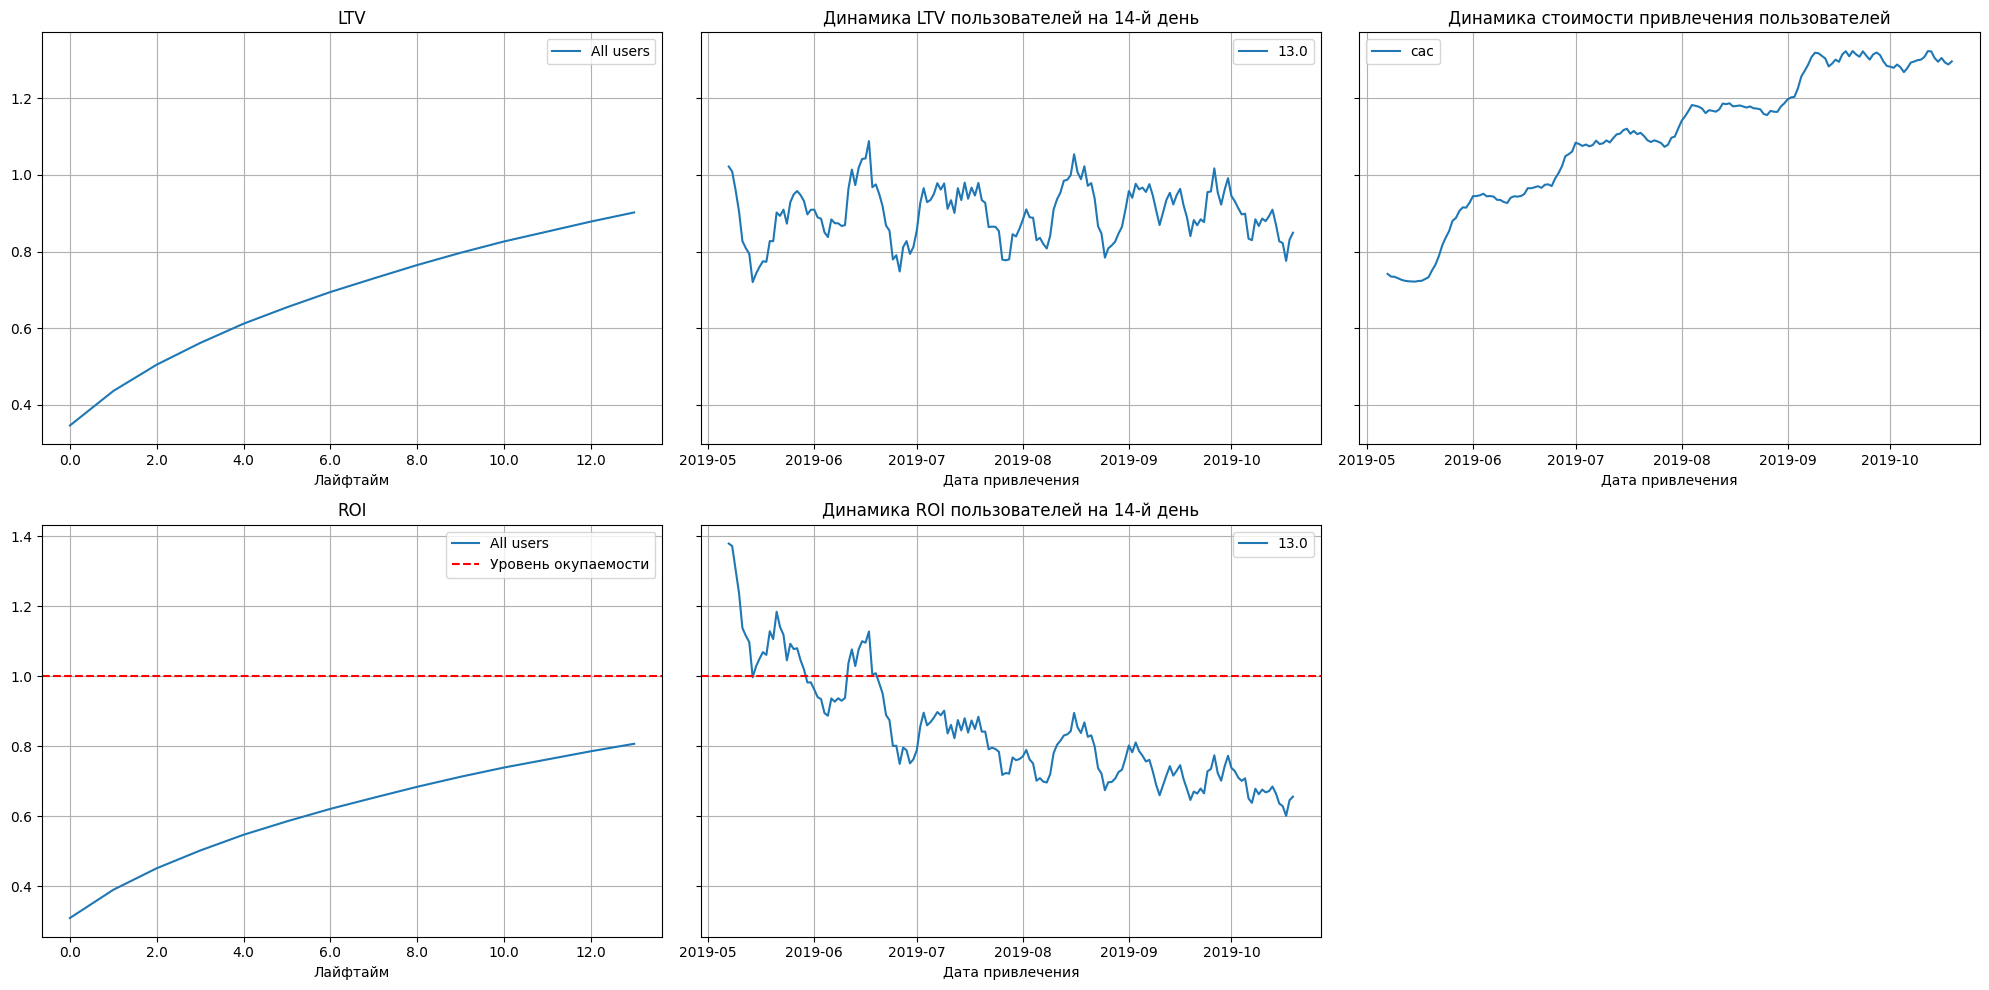

In [44]:
(result_raw,  # сырые данные
result_grouped,  # таблица LTV
result_in_time,  # таблица динамики LTV
roi_grouped,  # таблица ROI
roi_in_time) = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_ltv_roi(ltv=result_grouped,
             ltv_history=result_in_time,
             roi=roi_grouped,
             roi_history=roi_in_time,
             horizon=hor_days,
             window=7)

- Пользователи не окупаются на 14 день своей жизни. ROI равен 80%
- LTV 14 дня составляет примерно 0.9$
- В динамике по дате привлечения пользователей LTV достаточно стабилен, несмотря на некоторые сезонные колебания
- Судя по графику динамики ROI, окупаться клиенты перестали в июне. Причина кроется в увеличении CAC в тот же период

#### Конверсия и Удержание пользователей

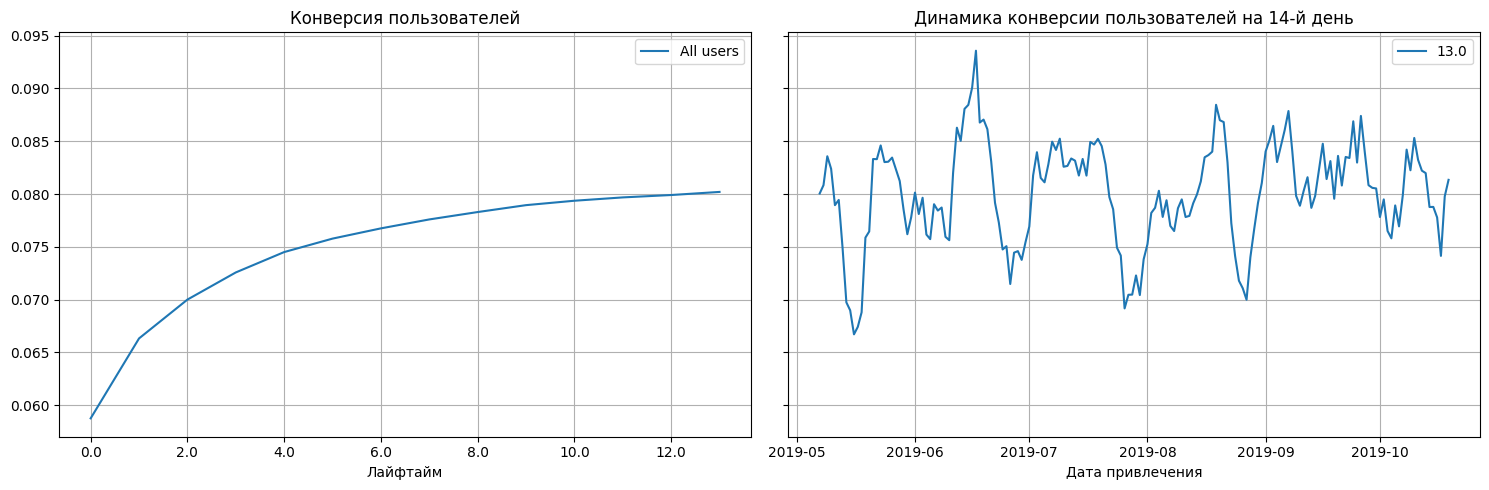

In [45]:
(result_raw, # сырые данные
result_grouped, # таблица конверсии
result_in_time) = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_conversion(conversion=result_grouped, conversion_history=result_in_time, horizon=hor_days, window=7)

- Наблюдается стремительный рост конверсии вплоть до 7 дня жизни. После же, уровень конверсии существенно не меняется
- Заметны колебания уровня конверсии, хотя в среднем её уровень стабилен

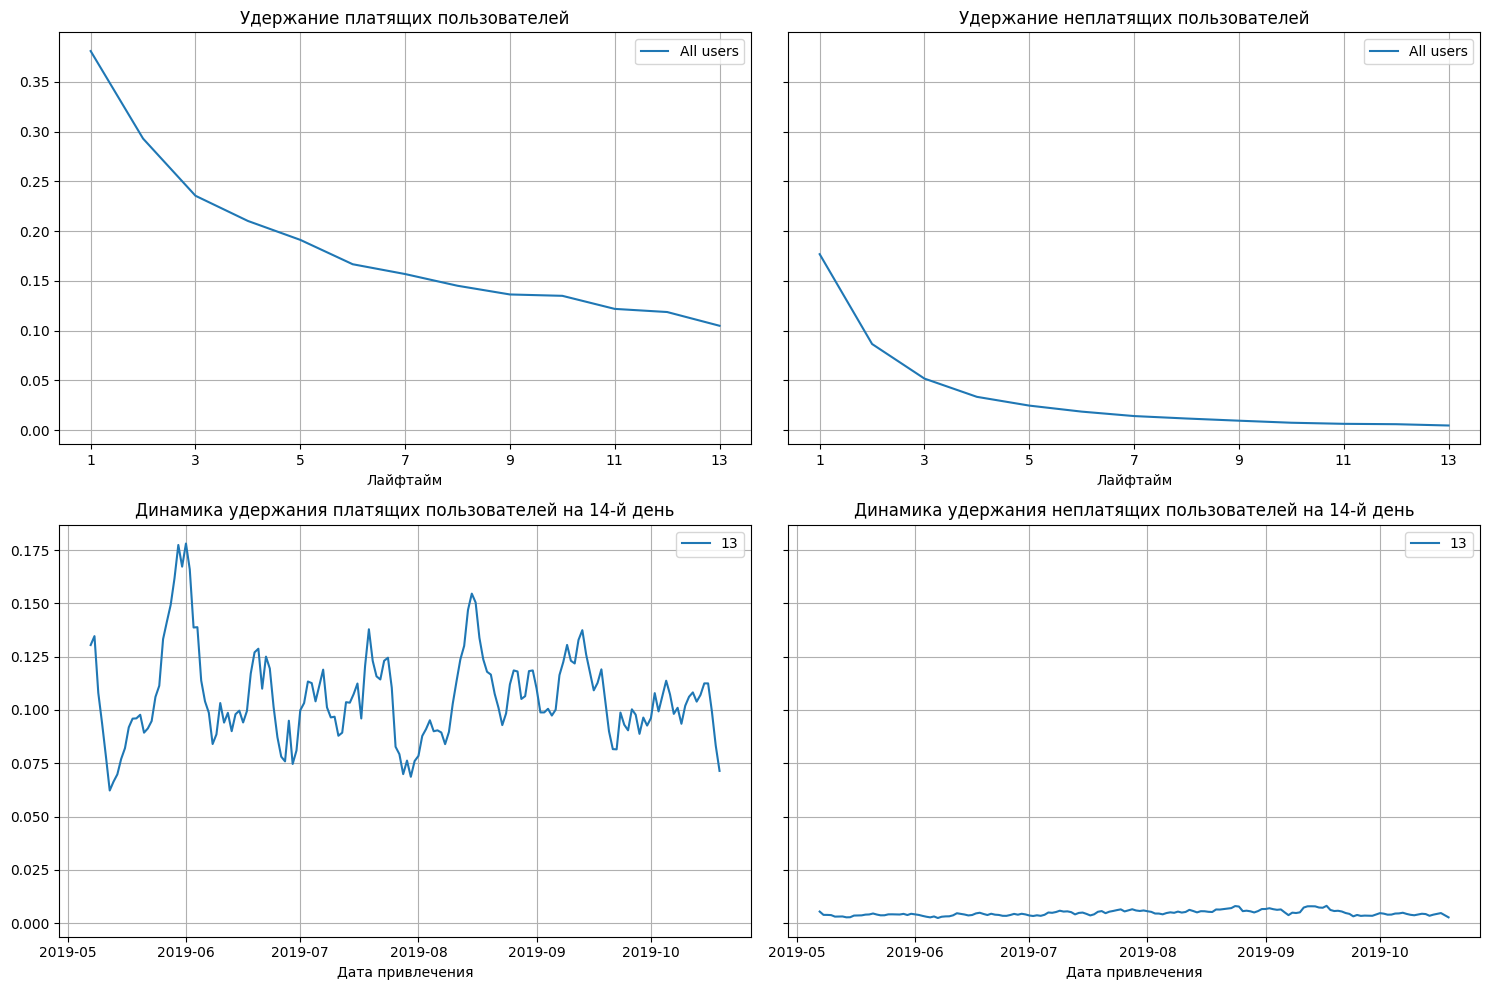

In [46]:
(result_raw,  # сырые данные
 result_grouped, # таблица конверсии
 result_in_time) = get_retention(
    profiles=profiles,
    sessions=sessions,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_retention(retention=result_grouped, retention_history=result_in_time, horizon=hor_days, window=7)

Для платящих:
- Retention стремительно падает уже на 2 день жизни
- Retention 14 дня составляет примерно 0.1
- Retention 14 дня стабилен независимо от даты привлечения пользователей

Для неплатящих
- Retention стремительно падает уже на 2 день жизни, а с начала второй недели он стремится к нулю
- Retention 14 дня практически равен 0 независимо от даты привлечения пользователей

#### Конверсия и Удержание пользователей по устройствам

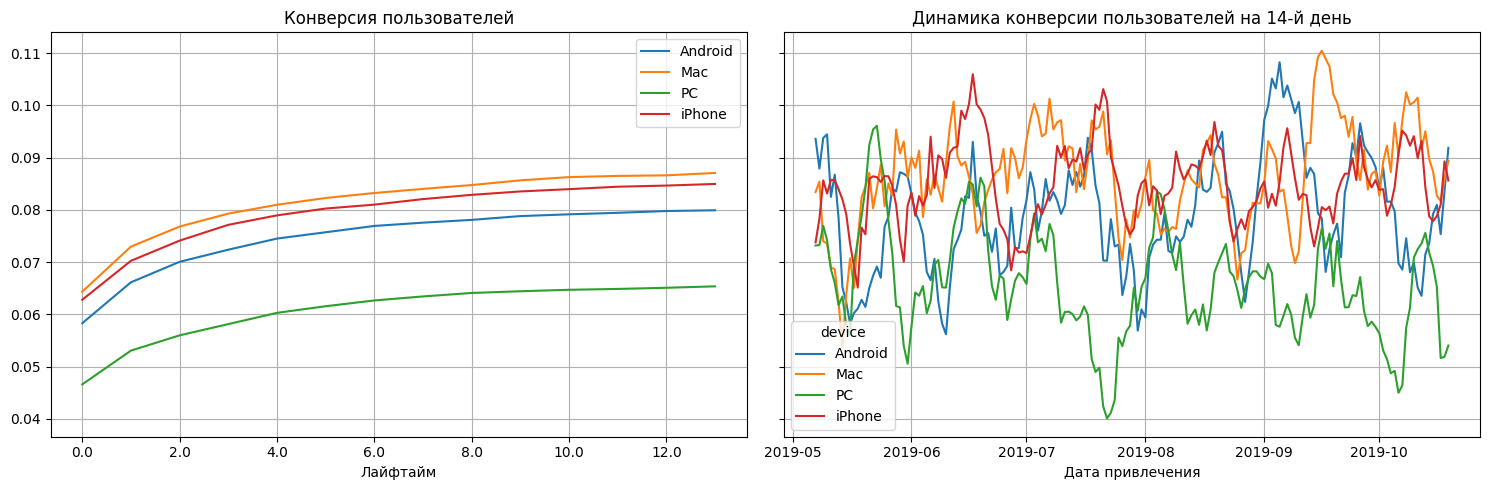

In [47]:
(result_raw, # сырые данные
result_grouped, # таблица конверсии
result_in_time) = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_conversion(conversion=result_grouped, conversion_history=result_in_time, horizon=hor_days, window=7)


- Конверсия 14 дня пользователей ПК ниже всех (6.5%). В динамике конверсии для ПК заметны существенные просадки
- Выше всего конверсия 14 дня у Mac и iPhone (8.5%)

In [ ]:
(result_raw,  # сырые данные
 result_grouped, # таблица конверсии
 result_in_time) = get_retention(
    profiles=profiles,
    sessions=sessions,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_retention(retention=result_grouped, retention_history=result_in_time, horizon=hor_days, window=7)

- Удерживаются пользователи ПК лучше всех - (Удержание 14 дня - 13%)
- Удержание пользователей Android и Mac примерно одинаково - (Удержание 14 дня - 11%)
- Удержание пользователей iPhone самое низкое - (Удержание 14 дня - 9%)

#### Конверсия и Удержание пользователей по странам¶

In [ ]:
(result_raw, # сырые данные
result_grouped, # таблица конверсии
result_in_time) = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_conversion(conversion=result_grouped, conversion_history=result_in_time, horizon=hor_days, window=7)

- Cамая высокая конверсия 14 дня в США - практически 10%
- Конверсии 14 дня для остальных стран равны 5%

In [ ]:
(result_raw,  # сырые данные
 result_grouped, # таблица конверсии
 result_in_time) = get_retention(
    profiles=profiles,
    sessions=sessions,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_retention(retention=result_grouped, retention_history=result_in_time, horizon=hor_days, window=7)

- Удержание 14 дня для США - 9%
- Удержание 14 дня для Германии - 14%
- Удержание 14 дня для Франции и Великобритании - 18%

#### Конверсия и Удержание пользователей по рекламным каналам¶

In [ ]:
(result_raw, # сырые данные
result_grouped, # таблица конверсии
result_in_time) = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_conversion(conversion=result_grouped, conversion_history=result_in_time, horizon=hor_days, window=7)

- Конверсия низкая (около 2.5-3%) у  OppleCreativeMedia, LeapBob, MediaTornado, YRabbit
- Конверсия средняя (около 5-7%) у WahooNetBanner, RocketSuperAds
- Конверсия высокая (около 9-12%) у TipTop, lambdaMediaAds, AdNonSense, FaceBoom

In [ ]:
(result_raw,  # сырые данные
 result_grouped, # таблица конверсии
 result_in_time) = get_retention(
    profiles=profiles,
    sessions=sessions,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_retention(retention=result_grouped, retention_history=result_in_time, horizon=hor_days, window=7)

- Удержание 14 дня крайне низкое (меньше 5%) для AdNonSense и FaceBoom
- Удержание 14 дня низкое (около 12%) для MediaTornado и Yrabbit
- Удержание 14 дня нормальное (чуть выше 20%) для всех остальных каналов

#### Окупаемость рекламы по устройствам.

In [ ]:
(result_raw,  # сырые данные
result_grouped,  # таблица LTV
result_in_time,  # таблица динамики LTV
roi_grouped,  # таблица ROI
roi_in_time) = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv=result_grouped,
             ltv_history=result_in_time,
             roi=roi_grouped,
             roi_history=roi_in_time,
             horizon=hor_days,
             window=7)

- Ниже всего LTV 14 дня у пользователей ПК (~0.81$). У пользователей Mac, iPhone и Android LTV 14 дня примерно одинаков (0.85)
- Пользователи ПК окупаются на 12 день жизни. ROI 14 дня чуть выше 100%
- Пользователи Android не окупаются. ROI 14 дня примерно 90%
- Пользователи iPhone и Mac не окупаются. ROI 14 дня равен примерно 70%
- LTV стабилен в независимости от даты привлечения пользователей, значит их качество примерно одинаково
- На графике динамике ROI наблюдается негативный тренд для всех устройств
- Серьёзные проблемы с окупаемостью начались в июне для всех устройств, кроме ПК - они стабильно перестали окупаться в августе (не считая некоторых просадок)
- Снижение ROI объясняется графиком CAC, который демонстрирует стремительное увеличение стоимости привлечения для всех устройств, начиная с июня. Особенно критично увеличение CAC для iPhone и Mac. При этом увеличение САС для пользователей ПК произошло в августе, что объясняет их окупаемость до этого месяца

#### Окупаемость рекламы по странам

In [ ]:
(result_raw,  # сырые данные
result_grouped,  # таблица LTV
result_in_time,  # таблица динамики LTV
roi_grouped,  # таблица ROI
roi_in_time) = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv=result_grouped,
             ltv_history=result_in_time,
             roi=roi_grouped,
             roi_history=roi_in_time,
             horizon=hor_days,
             window=7)

- США является лидером по уровню LTV
- Несмотря на сезонность, в среднем LTV остается стабилен для всех стран независимо от даты привлечения пользователей
- Предполагаю, что найдена одна из причин неокупаемости пользователей. Динамика CAC демонстрирует спад в мае для всех стран, кроме США, где стоимость привлечения пользователя крайне резко пошла вверх
- Для США следствием высокого CAC является ROI меньше 100%, начиная с середины мая
- В среднем, ROI 14 дня для США примернно 70%

#### Окупаемость рекламы по рекламным каналам

In [ ]:
(result_raw,  # сырые данные
result_grouped,  # таблица LTV
result_in_time,  # таблица динамики LTV
roi_grouped,  # таблица ROI
roi_in_time) = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=analysis_horizon,
    horizon_days=hor_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_ltv_roi(ltv=result_grouped,
             ltv_history=result_in_time,
             roi=roi_grouped,
             roi_history=roi_in_time,
             horizon=hor_days,
             window=7)

- Не окупаются TipTop, FaceBoom, AdNonSense
- OppleCreativeMedia и WahooNetBanner окупаются примерно на 6 день жизни пользователей
- Все остальные каналы окупаются на 3 день жизни. Для всех них ROI 14 дня выше 120%
- С июня по август включительно, ROI пользователей из YRabbit был очень высок. Это необходимо проанализировать дополнительно
- CAC для всех каналов остаётся примерно одинаковым, кроме TipTop, для которого CAC значительно увеличивается каждый месяц

#### Ответы на вопросы

1. Окупается ли реклама, направленная на привлечение пользователей в целом?
 - **Нет, реклама не окупается, ROI 14 дня около 80%**


2. Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Негативное влияние оказывают
    - Среди устройств:
        - Пользователи **Android** не окупаются. ROI 14 дня примерно 90%
        - Пользователи **iPhone** и **Mac** не окупаются. ROI 14 дня примерно 70%
    - Среди стран: **США** (ROI 14 дня примерно 70%)
    - Среди рекламных каналов: **TipTop, FaceBoom, AdNonSense** (ROI 14 дня примерно 50-80%)

**Чем могут быть вызваны проблемы окупаемости?**

1. Для устройств **iPhone**, **Android** и **Mac** проблемы окупаемости начались в июне.
    - Они вызваны резким увеличением CAC при стабильном LTV с поправкой на сезонность
    - Удержание 14 дня около 9-11% (в то время как для ПК - 13%)
  
    
2. В **США** проблема окупаемости также началась в июне.
    - Она вызвана резким увеличением CAC при стабильном LTV с поправкой на сезонность. При этом США имеет самый высокий LTV среди всех стран
    - Удержание 14 дня для США самое низкое среди всех стран - 9% (в то время как другие страны имеют от 15%)
    
    
3. Для рекламных каналов:

- **TipTop** имеет второй по величине LTV. При этом этот канал окупался до середины мая.

    - В тот момент произошло увеличение CAC, после продолжавшееся на протяжении всего периода исследования, еще больше уменьшая ROI. Для когорт пользователей, привлеченных с сентября ROI зафиксировался на уровне примерно 50%
    - Удержание 14 дня нормальное (чуть выше 20%)
    
    
- **FaceBoom** имеет стабильно невысокий LTV (< 1 на 14 день) при стабильно самом высоком CAC (> 1)

    - вследствие чего данный канал не окупался ни разу на протяжении исследования
    - Удержание 14 дня крайне низкое (меньше 5%)
    
    
- **AdNonSense** имеет схожую ситуацию, что и **FaceBoom**. Их показатели примерно одинаковы, данный канал также не окупался ни разу на протяжении исследования.

    -  Удержание 14 дня крайне низкое (меньше 5%)
     
     

### Выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

#### Общие выводы

- **LTV, CAC, ROI**
    - Пользователи не окупаются на 14 день своей жизни. ROI немного не дотягивает до 100%
    - LTV 14 дня составляет примерно 0.7$
    - В динамике по дате привлечения пользователей LTV достаточно стабилен, несмотря на некоторые сезонные колебания
    - Судя по графику динамики ROI, окупаться клиенты перестали во 2 половине июня. Причина кроется в увеличении CAC в тот же период


- **Конверсия общая**
    - Наблюдается стремительный рост конверсии вплоть до 7 дня жизни. После же, уровень конверсии существенно не меняется
    - Конверсия 14 дня у пользователей, привлеченных в мае была достаточно низкой. В последующие месяцы заметны колебания уровня конверсии, хотя в среднем её уровень стабилен
    
    
- **Конверсия в разбивке по устройствам**
    - Конверсия 14 дня пользователей ПК ниже всех (6.5%). В динамике конверсии для ПК заметны существенные просадки
    - Выше всего конверсия 14 дня у Mac и iPhone (8.5%)
    
    
- **Конверсия в разбивке по странам**
    - Cамая высокая конверсия 14 дня в США - практически 10%
    - Конверсии 14 дня для остальных стран равны 5%


- **Конверсия в разбивке по рекламным каналам**

    - Конверсия низкая (около 2.5-3%) у  OppleCreativeMedia, LeapBob, MediaTornado, YRabbit
    - Конверсия средняя (около 5-7%) у WahooNetBanner, RocketSuperAds
    - Конверсия высокая (около 9-12%) у TipTop, lambdaMediaAds, AdNonSense, FaceBoom




- **Общий Retention для платящих:**
    - Retention стремительно падает уже на 2 день жизни
    - Retention 14 дня составляет примерно 0.125
    - Retention 14 дня стабилен независимо от даты привлечения пользователей
    
    
- **Retention в разбивке по устройствам**
    - Удерживаются пользователи ПК лучше всех - (Удержание 14 дня - 13%)
    - Удержание пользователей Android и Mac примерно одинаково - (Удержание 14 дня - 11%)
    - Удержание пользователей iPhone самое низкое - (Удержание 14 дня - 9%)


- **Retention в разбивке по странам**
    - Удержание 14 дня для США - 9%
    - Удержание 14 дня для Германии - 14%
    - Удержание 14 дня для Франции и Великобритании - 18%


- **Retention в разбивке по рекламным каналам**
    - Удержание 14 дня крайне низкое (меньше 5%) для AdNonSense и FaceBoom
    - Удержание 14 дня низкое (около 12%) для MediaTornado и Yrabbit
    - Удержание 14 дня нормальное (чуть выше 20%) для всех остальных каналов


- **Retention для НЕплатящих:**
    - Retention стремительно падает уже на 2 день жизни, а с начала второй недели он стремится к нулю
    - Retention 14 дня практически равен 0 независимо от даты привлечения пользователей

#### Причины неокупаемости по устройствам

Пользователи Android не окупаются. ROI 14 дня примерно 90%
   - Увеличение CAC для Android в июне
   - Удержание 14 дня пользователей Android - 11%
    
Пользователи iPhone и Mac не окупаются. ROI 14 дня равен примерно 70%
   - Критичное увеличение CAC для iPhone и Mac в июне
   - Удержание 14 дня пользователей iPhone самое низкое - 9%
   - Удержание 14 дня пользователей Mac - 11%

#### Причины неокупаемости по странам

Не окупается только США. ROI 14 дня для США - 70%

- Существенное, резкое увеличение САС в мае, продолжавшееся весь период исследования
- Удержание 14 дня для США самое низкое среди стран - 9%

#### Причины неокупаемости по рекламным каналам

Лидеры по рекламным тратам - TipTop и FaceBoom - а также канал AdNonSense не окупаются:

TipTop (52% бюджета). ROI 14 дня - 50%

- Очень высокий CAC = 2.79
- TipTop окупался до середины мая. В тот момент произошло увеличение CAC, после продолжавшееся на протяжении всего периода исследования, еще больше уменьшая ROI. Для когорт пользователей, привлеченных с сентября ROI зафиксировался на уровне примерно 50%
- Средний уровень конверсии 14 дня - 9% (при лидере в 13%)

FaceBoom (31% бюджета). ROI 14 дня - 90%

- FaceBoom имеет стабильно невысокий LTV (< 1 на 14 день) при стабильно самом высоком CAC (> 1), вследствие чего данный канал не окупался ни разу на протяжении исследования.
- Удержание 14 дня крайне низкое (меньше 5%)

AdNonSense (4% бюджета). ROI 14 дня - 90%

- Ситуция очень похожа на FaceBoom
- AdNonSense имеет стабильно невысокий LTV (< 1 на 14 день) при стабильно высоком CAC (> 1), вследствие чего данный канал не окупался практически никогда
- Удержание 14 дня крайне низкое (меньше 5%)

#### Рекомендации маркетологам

**Лучшие каналы:** (рекомендуется привлекать пользователей из Европы в силу их низкой стоимости)

1. lambdaMediaAds
    - рекомендую вложить 50% бюджета
    
    
2. RocketSuperAds
    - рекомендую вложить 30% бюджета
    
    
3. WahooNetBanner
    - рекомендую вложить 10% бюджета

<div style="text-align: center">Отличный ROI (примерно 250%)</div>

| Название канала | Конверсия | Удержание |
|----------|----------|----------|
| YRabbit  | низкая | низкое |
| lambdaMediaAds | высокая | высокое |
| MediaTornado  | низкая | низкое |
| RocketSuperAds  | средняя | высокое  |
| LeapBob  | низкая  | высокое  |

<div style="text-align: center">Невысокий ROI (примерно 150%)</div>

| Название канала | Конверсия | Удержание |
|----------|----------|----------|
| OppleCreativeMedia  | низкая | высокое |
| WahooNetBanner | средняя | высокое |

Пояснения к таблицам

- Конверсия 14 дня низкая (около 2.5-3%)
- Конверсия 14 дня средняя (около 5-7%)
- Конверсия 14 дня высокая (около 9-12%)


- Удержание 14 дня крайне низкое (меньше 5%)
- Удержание 14 дня низкое (около 12%)
- Удержание 14 дня высокое (чуть выше 20%)
